# 0 - Prerequisitos

In [1]:
# install python packages
!pip install pandas numpy scipy scikit-learn matplotlib seaborn

In [1]:
from  urllib.request import urlopen
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

In [2]:
# function for parsing API data to dataframe
def read_data_api(url, data_path='results', read_level = 4):
  """Parse JSON data from MercadoLibre URL API.

    Keyword arguments:
    url -- API url to extract data
    data_path -- path to extract records from JSON data
  """
  json_url = urlopen(url)
  data = json.loads(json_url.read())

  return pd.json_normalize(data, record_path = data_path, max_level = read_level)

In [3]:
# function to convert a dict in a list in a dataframe to dataframe columns
def nested_list_dict(df):
  rows = []

  for data in df:
    for row in data:
      rows.append(row)

  return pd.DataFrame(rows, index=df.index)

In [4]:
def get_subcat(cat):
    """Get a list of subcategories or children categories from a category id.

      Keyword arguments:
      cat -- category id to read
    """
    return read_data_api('https://api.mercadolibre.com/categories/'+str(cat), data_path='children_categories')

In [5]:
def get_data(URL = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k&offset=', offset=0):
  """Get data from a MercadoLibre url API by increasing offset.

    Keyword arguments:
    url -- API url to extract data
    offset -- start offset
  """
  #URL = 'https://api.mercadolibre.com/sites/MCO/search?category=MCO2931&offset='
  #URL = 'https://api.mercadolibre.com/sites/MLA/search?category=MLA438566&offset='
  #URL = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k&offset='
  #URL = 'https://api.mercadolibre.com/sites/MCO/search?category=MCO157283&offset='
  #URL = url
  data = read_data_api(URL+str(offset))

  for i in range((offset + 50), 1000, 50):
    temp = read_data_api(URL+str(i+1))
    data = pd.concat([data, temp])

  return data.reset_index()

In [6]:
def get_data_by_cat(cat):
    """Get data from a category id using subcategories or children categories, using MercadoLibre API to read JSON data.

      Keyword arguments:
      cat -- category id to read
    """
    test = get_subcat(cat)
    data = pd.DataFrame()

    for i in test.id:
        url = 'https://api.mercadolibre.com/sites/MLA/search?category='+str(i)+'&offset='
        temp = get_data(URL = url)
        data = pd.concat([data, temp])
    
    return data.reset_index()

In [7]:
pd.options.display.float_format = '{:.2f}'.format

# 1 - Analisis Exploratorio

**Objetivo**

Analizar las publicaciones que se encuentran en la categoria *Consolas y Videojuegos*, de acuerdo a las categorias hijo o subcategorias

In [9]:
# obtain data
CAT = 'MLA1144'

subcats = get_subcat(CAT)
data = get_data_by_cat(CAT)
data.head(5)

,level_0,index,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,...,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,installments,prices
0,0,0,MLA906332763,MLA,Auriculares Gamer Kotion Each G9000 Black Y Blue,2160.00,None,ARS,487,14,...,TUxBQ0NBUGNiZGQx,Córdoba,,,nan,NaN,NaN,NaN,nan,nan
1,1,1,MLA885869798,MLA,Joystick Inalámbrico Sony Dualshock 4 Jet Black,9299.00,None,ARS,4,215,...,TUxBQkJBTDMxMDZa,Balvanera,,,33678187.00,NaN,NaN,NaN,nan,nan
2,2,2,MLA880563648,MLA,Joystick Inalámbrico Sony Dualshock 3 Black,1990.00,None,ARS,165,261,...,None,San Andres,,,nan,NaN,NaN,NaN,nan,nan
3,3,3,MLA833372951,MLA,Joystick Inalámbrico Sony Dualshock 4 Magma Red,9010.00,None,ARS,43,216,...,TUxBQk1PTjUxOTJa,Monserrat,,,nan,NaN,NaN,NaN,nan,nan
4,4,4,MLA906120473,MLA,Joystick Inalámbrico Sony Dualshock 4 Midnight...,9030.00,None,ARS,1,4,...,TUxBQkJFTDcyNTJa,Belgrano,,,nan,NaN,NaN,NaN,nan,nan


In [10]:
# check for column datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Columns: 102 entries, level_0 to prices
dtypes: bool(5), float64(24), int64(6), object(67)
memory usage: 5.2+ MB


In [11]:
# drop column index, cast price cols to float
data.drop(columns=['index'])
data['price'] = data['price'].astype('float64')
data['original_price'] = data['original_price'].astype('float64')

In [12]:
# filter for original_price not null
df = data[data.original_price.notnull()]
df

,level_0,index,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,...,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,installments,prices
5,5,5,MLA883194777,MLA,Joystick Inalámbrico Microsoft Xbox One Grey Y...,9699.00,None,ARS,381,732,...,None,Villa Celina,,,nan,NaN,NaN,NaN,nan,nan
22,22,22,MLA901073234,MLA,Joystick Inalámbrico Microsoft Xbox Series X/s...,12999.00,None,ARS,192,80,...,None,Villa Celina,,,33678187.00,NaN,NaN,NaN,nan,nan
23,23,23,MLA880512479,MLA,Auriculares Gamer Gadnic A500 Go Black Y Blue,3799.00,None,ARS,76,252,...,TUxBQlZJTDQyMjFa,Villa Ortúzar,,,nan,NaN,NaN,NaN,nan,nan
28,28,28,MLA761056939,MLA,Accesorios Ps4 Cargador Rapido Joystick Play 4...,1711.40,None,ARS,150,500,...,None,Liniers,,,nan,NaN,NaN,NaN,nan,nan
31,31,31,MLA882860881,MLA,Auriculares Gamer Nubwo N1 Pro Rgb Pc Ps4 Xbox,2895.20,None,ARS,100,500,...,None,Ciudad Autonoma de Buenos Aires,,,nan,NaN,NaN,NaN,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,930,30,MLA899305716,MLA,Diablo 3: Reaper Of Souls/ps3/digit,284.05,None,ARS,1,5,...,TUxBQ0NBUGNiZGQx,Córdoba,,,nan,NaN,NaN,NaN,nan,nan
5900,955,5,MLA739871335,MLA,Dark Souls 3 Complete Edition Ps4 Fisico Sella...,4084.05,None,ARS,1,50,...,None,Ramos Mejía,,,nan,NaN,NaN,NaN,nan,nan
5910,965,15,MLA861773770,MLA,Ultimate Stealth Triple Pack Ps3 3 Juegos En 1...,245.64,None,ARS,500,50,...,None,Cortaderas,,,nan,NaN,NaN,NaN,nan,nan
5914,969,19,MLA885253958,MLA,Knack Ps4 Ingles Juego Fisico Original,1510.00,None,ARS,1,5,...,None,Caballito,,,nan,NaN,NaN,NaN,nan,nan


In [13]:
# check descriptive stats
df.describe()

,level_0,index,price,available_quantity,sold_quantity,original_price,order_backend,seller.id,seller.eshop.eshop_id,seller.eshop.eshop_status_id,...,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,installments.quantity,installments.amount,installments.rate,differential_pricing.id,installments,prices
count,357.00,357.00,357.00,357.00,357.00,357.00,357.00,357.00,230.00,230.00,...,357.00,357.00,357.00,357.00,357.00,357.00,357.00,47.00,0.00,0.00
mean,362.71,23.56,5232.67,522.96,145.04,6354.02,24.71,205292736.49,225159.72,1.15,...,172.86,10764.20,0.00,53.18,11.21,776.32,60.34,33678187.00,nan,nan
std,307.28,13.90,10476.56,4585.00,173.96,13137.69,13.95,171304983.62,153532.96,0.36,...,381.37,19218.94,0.00,100.92,2.03,1591.55,24.39,0.00,nan,nan
min,0.00,0.00,130.00,1.00,0.00,149.00,1.00,680515.00,1118.00,1.00,...,0.00,37.00,0.00,0.00,6.00,18.44,0.00,33678187.00,nan,nan
25%,88.00,12.00,1199.25,1.00,25.00,1490.00,13.00,82264400.00,38728.00,1.00,...,1.00,1310.00,0.00,2.00,12.00,173.20,70.17,33678187.00,nan,nan
50%,265.00,23.00,2799.00,1.00,50.00,3199.00,24.00,137081041.00,251644.50,1.00,...,18.00,3458.00,0.00,13.00,12.00,396.92,70.17,33678187.00,nan,nan
75%,613.00,35.00,4598.16,50.00,250.00,5990.00,36.00,292433851.00,358018.50,1.00,...,133.00,9458.00,0.01,64.00,12.00,673.50,70.17,33678187.00,nan,nan
max,995.00,49.00,69999.00,50000.00,732.00,99699.00,50.00,694460122.00,453740.00,2.00,...,2393.00,100051.00,0.02,794.00,12.00,11666.50,70.17,33678187.00,nan,nan


In [14]:
# create a new feature extracted from attributes array (quick and dirty)
temp = df.apply(lambda x: x['attributes'][0],axis=1)
df['marca'] = temp.apply(lambda x: str(x['value_name']).upper())
df['marca']

5       MICROSOFT
22      MICROSOFT
23       ABLUE038
28          SEISA
31          NUBWO
          ...    
5875           NO
5900           SÍ
5910           NO
5914           NO
5917           SÍ
Name: marca, Length: 357, dtype: object

In [15]:
# create a new feature, Pct difference between price and original price
df['pct'] = (1 - df['price']/df['original_price'])*100

### Estadisticas descriptivas de los descuentos ###

In [16]:
df['pct'].describe()

count   357.00
mean     14.78
std      10.48
min       4.88
25%       6.00
50%      11.49
75%      20.00
max      77.80
Name: pct, dtype: float64

El descuento minimo encontrado es 3.5%, el mayor descuento es 77%, y en promedio los descuentos son del 10.5%

### ¿Como es la distribucion de los porcentajes de descuento? ###

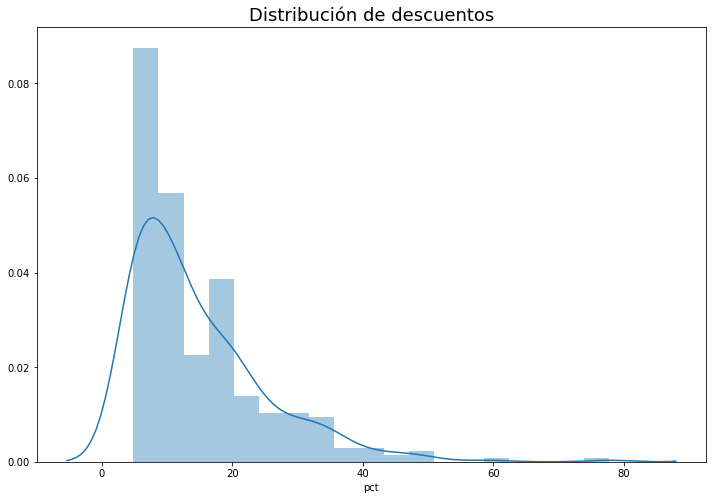

In [17]:
plt.figure(figsize=(12,8))
sns.distplot(df.pct)
plt.title('Distribución de descuentos', size=18)
plt.legend
plt.show()

Los porcentajes de descuento se concentran alrededor del 10 y 20 por ciento

### ¿Como son los descuentos por categoria? ###

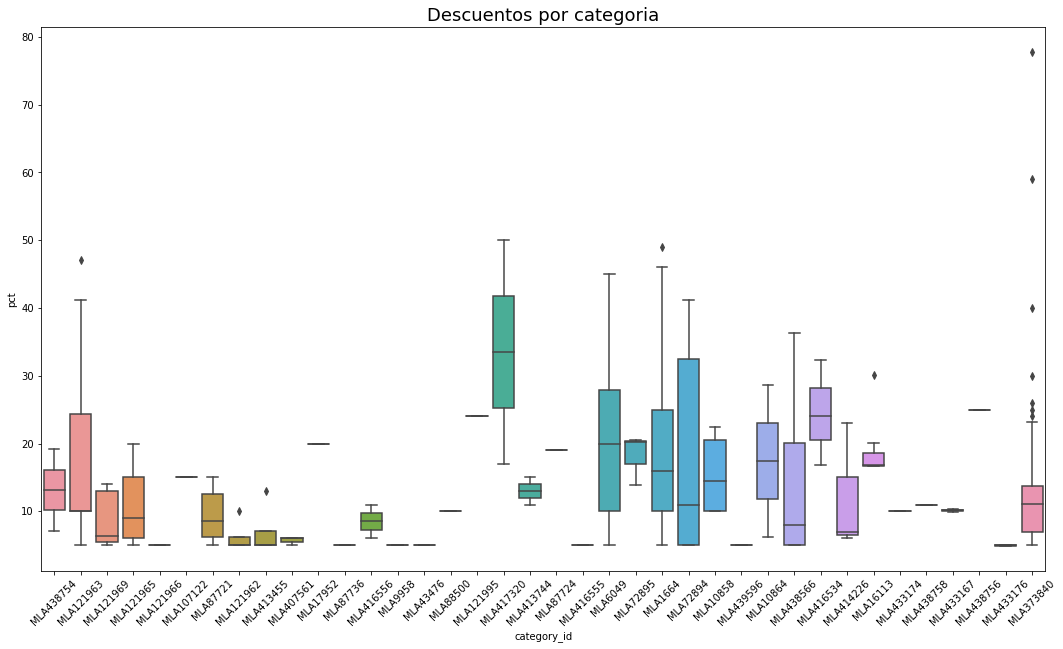

In [18]:
fmt=ScalarFormatter(useOffset=False)
fmt.set_scientific(False)

plt.figure(figsize=(18,10))
ax = sns.boxplot(x="category_id", y="pct", data=df)
ax.yaxis.set_major_formatter(fmt)
plt.xticks(rotation=45)
plt.title('Descuentos por categoria', size=18)
plt.legend
plt.show()

¿Cual es la categoria que tiene, en promedio, mayores descuentos?: MLA417320 (Skins)

¿Cual es la que tiene menores descuentos?: MLA121966 (Tarjetas Prepagas)

¿En cual categoria los descuentos son mas variados?: MLA6049 (Auriculares)

¿En cual son similares?: MLA87724 (Joysticks)

¿Cuales categorias tienen pocas ofertas con descuentos mayores al promedio de la misma? MLA121963 (Auriculares), MLA72894 (Joysticks)

¿Que categorias tienen descuentos atipicos?: MLA1664 (Micrófonos), MLA373840 (Videojuegos)

¿Que categorias tienen pocos productos?: En general, las que aparecen como una recta en la grafica, p.e: MLA438756 (Otros), MLA433167 (Motores Centrales), posiblemente correspondan a productos mal categorizados

Veriquemos la ultima afirmación

In [19]:
df['category_id'].value_counts()

MLA373840    102
MLA6049       75
MLA438566     36
MLA121963     27
MLA121965     17
MLA1664       15
MLA16113       7
MLA407561      7
MLA87721       6
MLA10858       6
MLA72894       5
MLA121969      5
MLA121962      4
MLA413455      4
MLA414226      3
MLA433176      3
MLA416534      3
MLA72895       3
MLA438754      2
MLA10864       2
MLA121966      2
MLA416556      2
MLA413744      2
MLA87736       2
MLA417320      2
MLA88500       2
MLA433167      2
MLA87724       1
MLA438758      1
MLA17952       1
MLA439596      1
MLA438756      1
MLA107122      1
MLA9958        1
MLA416555      1
MLA121995      1
MLA433174      1
MLA43476       1
Name: category_id, dtype: int64

Seleccionemos unicamente las categorias que no tengan pocas ofertas

In [20]:
cat_select = df['category_id'].value_counts()[df['category_id'].value_counts()>3].index
cat_select

Index(['MLA373840', 'MLA6049', 'MLA438566', 'MLA121963', 'MLA121965',
       'MLA1664', 'MLA16113', 'MLA407561', 'MLA87721', 'MLA10858', 'MLA72894',
       'MLA121969', 'MLA121962', 'MLA413455'],
      dtype='object')

In [21]:
df = df[df['category_id'].isin(cat_select)]
df

,level_0,index,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,...,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,installments,prices,marca,pct
23,23,23,MLA880512479,MLA,Auriculares Gamer Gadnic A500 Go Black Y Blue,3799.00,None,ARS,76,252,...,,,nan,NaN,NaN,NaN,nan,nan,ABLUE038,35.05
28,28,28,MLA761056939,MLA,Accesorios Ps4 Cargador Rapido Joystick Play 4...,1711.40,None,ARS,150,500,...,,,nan,NaN,NaN,NaN,nan,nan,SEISA,14.00
31,31,31,MLA882860881,MLA,Auriculares Gamer Nubwo N1 Pro Rgb Pc Ps4 Xbox,2895.20,None,ARS,100,500,...,,,nan,NaN,NaN,NaN,nan,nan,NUBWO,12.00
34,34,34,MLA878200436,MLA,Repuesto Stick Analogico Control Joystick Orig...,496.00,None,ARS,250,500,...,,,nan,NaN,NaN,NaN,nan,nan,ALPS,20.00
46,46,46,MLA797659475,MLA,Base Soporte Cargador 2 Joystick Doble Ps4 Sli...,1328.00,None,ARS,1,500,...,,,nan,NaN,NaN,NaN,nan,nan,OTRAS MARCAS,5.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,930,30,MLA899305716,MLA,Diablo 3: Reaper Of Souls/ps3/digit,284.05,None,ARS,1,5,...,,,nan,NaN,NaN,NaN,nan,nan,NO,5.00
5900,955,5,MLA739871335,MLA,Dark Souls 3 Complete Edition Ps4 Fisico Sella...,4084.05,None,ARS,1,50,...,,,nan,NaN,NaN,NaN,nan,nan,SÍ,5.00
5910,965,15,MLA861773770,MLA,Ultimate Stealth Triple Pack Ps3 3 Juegos En 1...,245.64,None,ARS,500,50,...,,,nan,NaN,NaN,NaN,nan,nan,NO,8.00
5914,969,19,MLA885253958,MLA,Knack Ps4 Ingles Juego Fisico Original,1510.00,None,ARS,1,5,...,,,nan,NaN,NaN,NaN,nan,nan,NO,11.70


### ¿Como son los descuentos por tipo de compra? ###

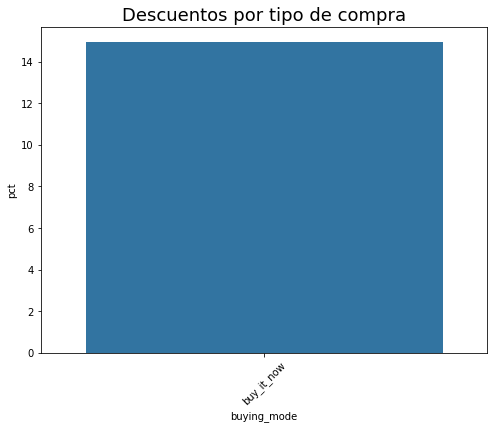

In [22]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x="buying_mode", y="pct", data=df, ci=None)
ax.yaxis.set_major_formatter(fmt)
plt.xticks(rotation=45)
plt.title('Descuentos por tipo de compra', size=18)
plt.legend
plt.show()

Todas las ofertas son de compra directa

### Descuentos por provincias ###

Miremos la cantidas de ofertas por provincia

In [23]:
df['seller_address.state.name'].value_counts()

Capital Federal    221
Buenos Aires        50
Entre Ríos          20
Santa Fe             7
Córdoba              6
Salta                6
San Luis             5
Chaco                1
Name: seller_address.state.name, dtype: int64

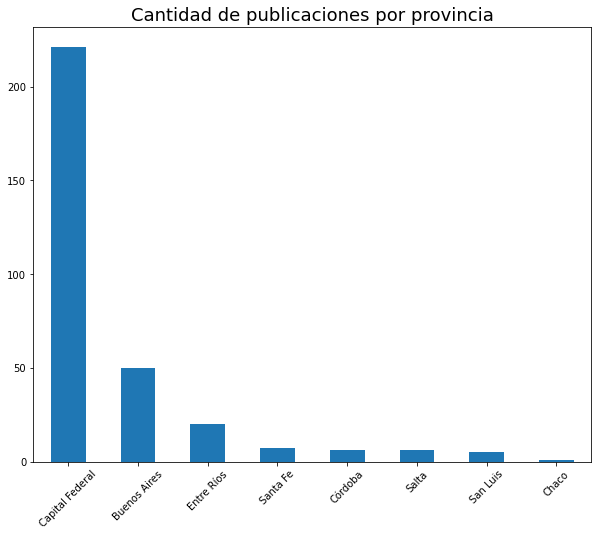

In [24]:
plt.figure(figsize=(10,8))
df['seller_address.state.name'].value_counts().plot.bar()
plt.xticks(rotation=45)
plt.title('Cantidad de publicaciones por provincia', size=18)
plt.legend
plt.show()

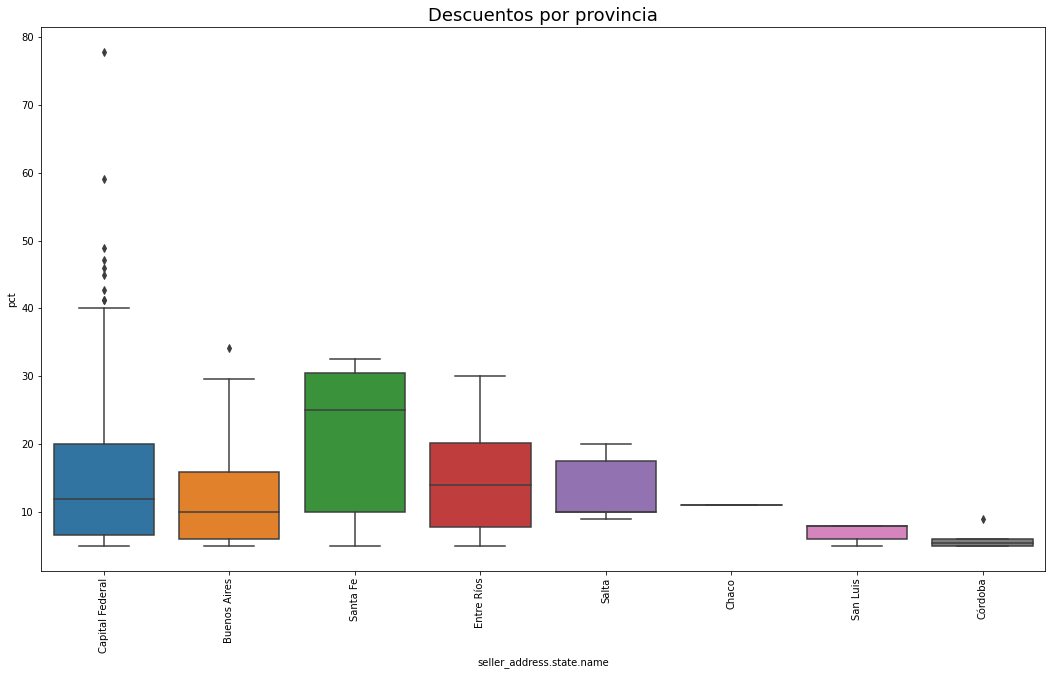

In [25]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(x="seller_address.state.name", y="pct", data=df)
ax.yaxis.set_major_formatter(fmt)
plt.title('Descuentos por provincia', size=18)
plt.xticks(rotation=90)
plt.show()

¿Cual provincia tiene los mayores descuentos en promedio?: Santa Fe

¿Cual es la que tiene menores descuentos?: San Luis y Córdoba

¿Que provincia tiene ofertas con descuentos más variados?: Capital Federal

¿En cual son parecidos?: San Luis

¿Que provincia tiene, en promedio, los menores descuentos? Buenos Aires

¿Cual tiene los mayores descuentos?: Santa Fe

¿Que provincias tienen descuentos atipicos? Capital Federal y Buenos Aires

#### Conclusiones ####

* Capital Federal tiene el mayor número de publicaciones, con los descuentos más variados
* Buenos Aires tiene el segundo mayor número de publicaciones, pero tiene los menores descuentos


* Santa Fe tiene pocas publicaciones, pero descuentos variados. Curiosamente corresponden a dos categorias (Auriculares, Joysticks)

In [26]:
df['category_id'][df['seller_address.state.name'] == 'Santa Fe'].value_counts()

MLA6049     5
MLA72894    2
Name: category_id, dtype: int64

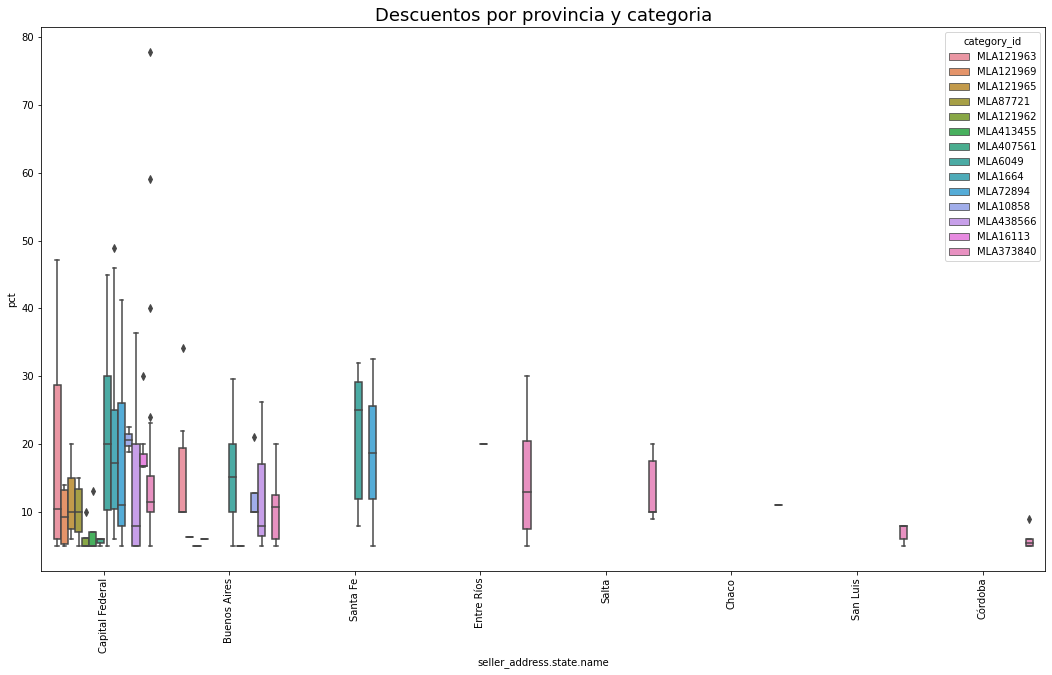

In [27]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(x="seller_address.state.name", y="pct", hue='category_id', data=df)
ax.yaxis.set_major_formatter(fmt)
plt.title('Descuentos por provincia y categoria', size=18)
plt.xticks(rotation=90)
plt.show()

Capital Federal concentra la mayor variedad de categorias, las demás provincias tienes publicaciones de una o dos categorias

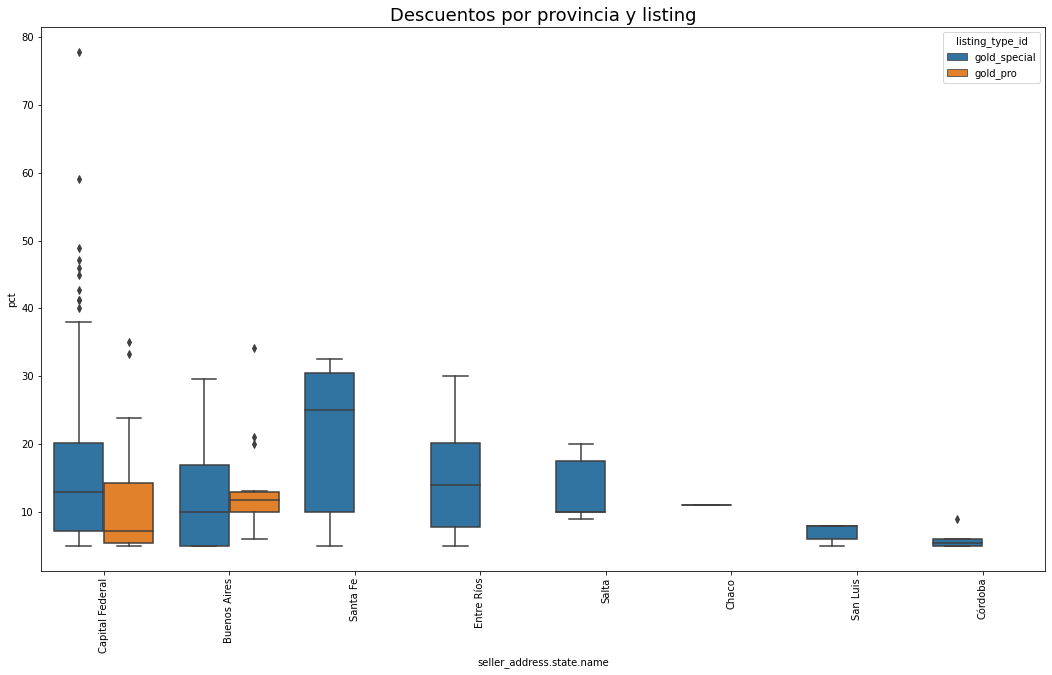

In [28]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(x="seller_address.state.name", y="pct", hue='listing_type_id', data=df)
ax.yaxis.set_major_formatter(fmt)
plt.title('Descuentos por provincia y listing', size=18)
plt.xticks(rotation=90)
plt.show()

Solo Capital Federal y Buenos Aires tienen publicaciones con los dos tipos de listing.
No hay diferencias en los descuentos por tipo de listing, mientras en Capital Federal el tipo gold_special tiene los mayores descuentos; en Buenos Aires es el tipo gold_pro


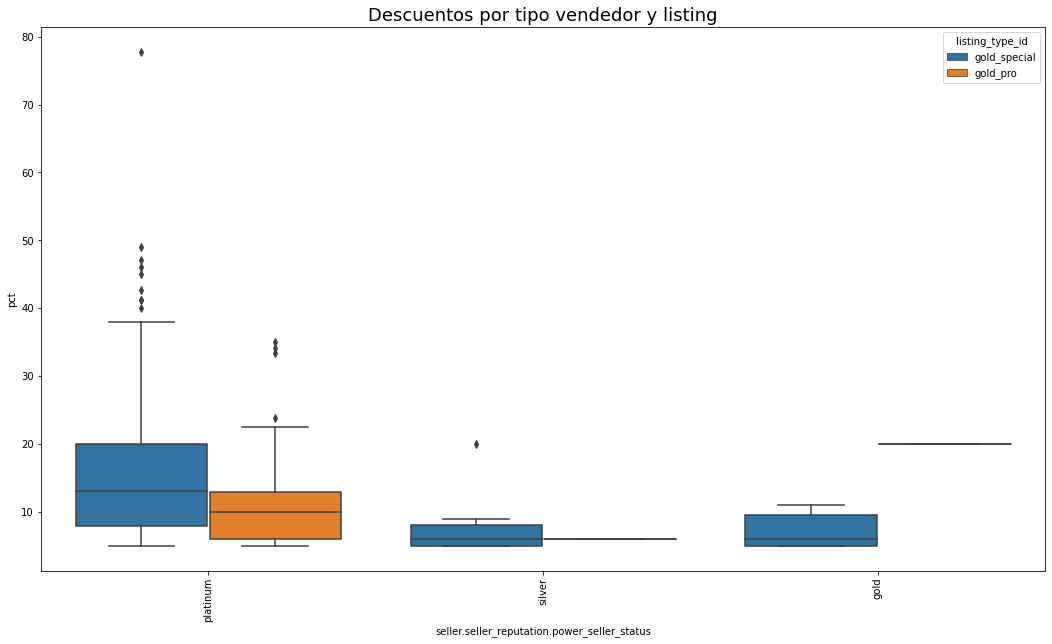

In [31]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(x='seller.seller_reputation.power_seller_status', y="pct", hue='listing_type_id', data=df)
ax.yaxis.set_major_formatter(fmt)
plt.title('Descuentos por tipo vendedor y listing', size=18)
plt.xticks(rotation=90)
plt.show()

Los mayores descuentos se encuentran en publicaciones de vendedores platinum. Estos son los unicos que tienen el listing gold_pro.